In [1]:
from utils import read_csv_data, clean_location

data = read_csv_data("../data/processed_job_postings_large_noNA.csv", 
                     ["industry", "work_type", "location", "formatted_experience_level",
                      "name", "cleaned_title", "cleaned_description", "title_emb"],
                     "salary_level")
data = clean_location(data, 2)
import random
random.seed(42)
random.shuffle(data)

train_data = data[:10000]
val_data = data[10000:13000]
test_data = data[13000:]

In [2]:
from utils import build_column_vocabulary

vocab_industry = build_column_vocabulary(train_data, 0)
vocab_type = build_column_vocabulary(train_data, 1)
vocab_state = build_column_vocabulary(train_data, 2)
vocab_level = build_column_vocabulary(train_data, 3)

In [3]:
import torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

targets = [data[i][1] for i in range(len(data))]

labels = ['10K-'] + [f"{i}K - {i + 10}K" for i in range(10, 150, 10)] + ['160K+']
label_to_int = {label: i for i, label in enumerate(labels)}

targets = list(map(lambda x: label_to_int[x], targets))

targets = torch.tensor(targets)

train_targets = targets[:10000]
val_targets = targets[10000:13000]
test_targets = targets[13000:]

In [4]:
torch.cuda.empty_cache()

In [5]:
from utils import convert_to_one_hot
import torch

train_cat_features = convert_to_one_hot(train_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])

val_cat_features = convert_to_one_hot(val_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])

test_cat_features = convert_to_one_hot(test_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert Lists to Tensors
train_cat_features = torch.stack(train_cat_features).to(device)
val_cat_features = torch.stack(val_cat_features).to(device)
test_cat_features = torch.stack(test_cat_features).to(device)

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right" 
a = tokenizer('hello this is a test',
         truncation=True,
         padding='max_length',
         max_length=512,
         return_tensors="pt")

In [7]:
from gpt1 import GPT1Dataset

semantic_items = [item[0][4] + ' ' + item[0][5] + ' ' + item[0][6] for item in train_data]
input_ids, attention_mask = [], []
for description in semantic_items:
    encoding = tokenizer(description,
                         truncation=True,
                         padding='max_length',
                         max_length=512,
                         return_tensors="pt")
    # input_ids.append(encoding['input_ids'].squeeze())
    # attention_mask.append(encoding['attention_mask'].squeeze())
    input_ids.append(encoding['input_ids'][0])
    attention_mask.append(encoding['attention_mask'][0])

# Convert Lists to Tensors
input_ids = torch.stack(input_ids).to(device)
attention_mask = torch.stack(attention_mask).to(device)

labels = [target for target in train_targets]

train_dataset = GPT1Dataset(input_ids, attention_mask, train_cat_features, labels)

In [8]:
semantic_items = [item[0][4] + ' ' + item[0][5] + ' ' + item[0][6] for item in val_data]
input_ids, attention_mask = [], []
for description in semantic_items:
    encoding = tokenizer(description,
                         truncation=True,
                         padding='max_length',
                         max_length=512,
                         return_tensors="pt")
    # input_ids.append(encoding['input_ids'].squeeze())
    # attention_mask.append(encoding['attention_mask'].squeeze())
    input_ids.append(encoding['input_ids'][0])
    attention_mask.append(encoding['attention_mask'][0])

# Convert Lists to Tensors
input_ids = torch.stack(input_ids).to(device)
attention_mask = torch.stack(attention_mask).to(device)

labels = [target for target in val_targets]

val_dataset = GPT1Dataset(input_ids, attention_mask, val_cat_features, labels)

In [9]:
semantic_items = [item[0][4] + ' ' + item[0][5] + ' ' + item[0][6] for item in test_data]
input_ids, attention_mask = [], []
for description in semantic_items:
    encoding = tokenizer(description,
                         truncation=True,
                         padding='max_length',
                         max_length=512,
                         return_tensors="pt")
    # input_ids.append(encoding['input_ids'].squeeze())
    # attention_mask.append(encoding['attention_mask'].squeeze())
    input_ids.append(encoding['input_ids'][0])
    attention_mask.append(encoding['attention_mask'][0])

# Convert Lists to Tensors
input_ids = torch.stack(input_ids).to(device)
attention_mask = torch.stack(attention_mask).to(device)

labels = [target for target in test_targets]

test_dataset = GPT1Dataset(input_ids, attention_mask, test_cat_features, labels)

Iter 50: Loss: 2.4024930000305176 Train Acc: 0.13866666666666666, Validation Acc: 0.15533333333333332
Iter 100: Loss: 2.62434458732605 Train Acc: 0.11, Validation Acc: 0.13133333333333333
Iter 150: Loss: 2.9670426845550537 Train Acc: 0.10533333333333333, Validation Acc: 0.09933333333333333
Iter 200: Loss: 2.655256986618042 Train Acc: 0.13266666666666665, Validation Acc: 0.146
Iter 250: Loss: 3.0263419151306152 Train Acc: 0.12266666666666666, Validation Acc: 0.11733333333333333
Iter 300: Loss: 2.745605230331421 Train Acc: 0.128, Validation Acc: 0.11266666666666666
Iter 350: Loss: 2.791489839553833 Train Acc: 0.13066666666666665, Validation Acc: 0.14
Iter 400: Loss: 2.7222161293029785 Train Acc: 0.21, Validation Acc: 0.208
Iter 450: Loss: 2.7470786571502686 Train Acc: 0.182, Validation Acc: 0.16266666666666665
Iter 500: Loss: 3.064814329147339 Train Acc: 0.214, Validation Acc: 0.21533333333333332
Iter 550: Loss: 2.481489658355713 Train Acc: 0.20066666666666666, Validation Acc: 0.21666666

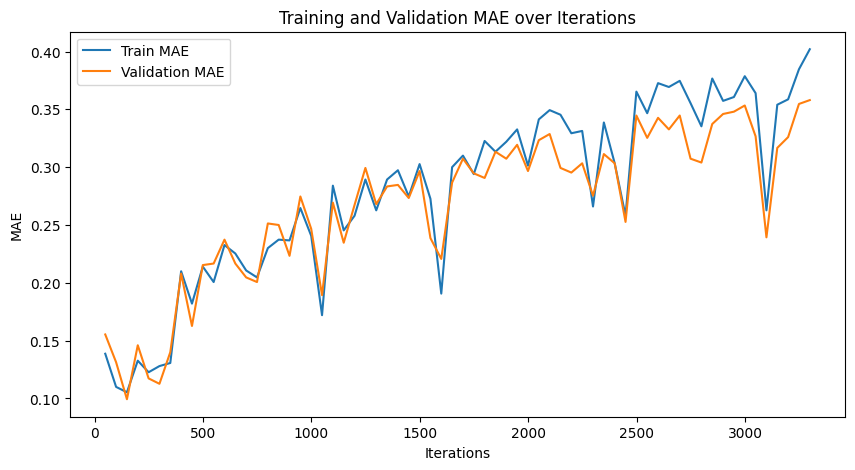

In [10]:
from bert import Bert
from gpt1 import train_classifier
"""remember to use gpu i.e. model.to(device) device = 'cuda' """

model = Bert(len(vocab_type) + len(vocab_industry) + len(vocab_state) + len(vocab_level), output_size=len(labels))
model.to(device)

train_classifier(model, train_data=train_dataset, val_data=val_dataset, batch_size=25, num_epochs=5)

In [15]:
from torch.utils.data import DataLoader

def _collate_batch(batch):
    """Custom collate function for handling batches of data where all input tensors are of the same length."""

    # Separate and stack the data directly since all tensors are already of the same length
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    categorical_features = torch.stack([item['categorical_features'] for item in batch]).float()
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.float).to(device)

    return input_ids, attention_mask, categorical_features, labels

def calculate_accuracy(model, dataloader: DataLoader) -> float:
    """
    Calculate the accuracy for a model over a given dataloader.

    Args:
        model: The model to evaluate.
        dataloader (DataLoader): The DataLoader containing the dataset.

    Returns:
        float: The accuracy of the model.
    """
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for input_ids, attention_mask, categorical_features, labels in dataloader:
            outputs = model(input_ids, attention_mask, categorical_features)
            outputs = outputs.squeeze()  # Adjust shape if necessary

            predictions = torch.argmax(outputs, dim=1)
            total_correct += torch.sum(predictions == labels).item()
            total_count += labels.size(0)
        return total_correct / total_count

In [16]:
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True, collate_fn=_collate_batch)
calculate_accuracy(model, train_loader)

0.3842

In [17]:
val_loader = DataLoader(val_dataset, batch_size=25, shuffle=True, collate_fn=_collate_batch)
calculate_accuracy(model, val_loader)

0.33266666666666667

In [18]:
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=True, collate_fn=_collate_batch)
calculate_accuracy(model, test_loader)

0.30510314875135724

In [10]:
import torch.nn as nn
from transformers import OpenAIGPTModel
class GPT1_3LL(nn.Module):
    def __init__(self, num_categorical_features):
        super(GPT1_3LL, self).__init__()

        self.gpt = OpenAIGPTModel.from_pretrained("openai-gpt")

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.gpt.config.hidden_size + num_categorical_features, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.dropout = nn.Dropout(0.1)
        self.output = nn.Linear(100, 1)  # Output layer for salary prediction

    def forward(self, input_ids, attention_mask, categorical_features):
        # Process textual input through GPT
        outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)

        text_features = outputs.last_hidden_state[:, -1, :]  # Use the last token's representation

        # Concatenate text features with categorical features
        combined_features = torch.cat((text_features, categorical_features), dim=1)
        combined_features = self.fc1(combined_features)
        x = self.relu(combined_features)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.output(x)

        return x

In [11]:
model2 = GPT1_3LL(len(vocab_type) + len(vocab_industry) + len(vocab_state) + len(vocab_level))
model2.to(device)

train_model(model2, train_data=train_dataset, val_data=val_dataset, batch_size=20, eval_batch_size=20)

Iter 50: Loss: 2304969216.0 Train mae 43995.17275, Validation mae 133732.32808333333
Iter 100: Loss: 2342991872.0 Train mae 40187.832708333335, Validation mae 129563.01847916667
Iter 150: Loss: 2517573632.0 Train mae 41184.2993125, Validation mae 131211.11129166666
Iter 200: Loss: 1892202112.0 Train mae 46290.084375, Validation mae 136913.785375
Iter 250: Loss: 9334715392.0 Train mae 83573.45725, Validation mae 173041.46491666668
Iter 300: Loss: 6555491840.0 Train mae 61665.673625, Validation mae 151432.96091666666
Iter 350: Loss: 621434112.0 Train mae 39524.65902083334, Validation mae 129395.229
Iter 400: Loss: 2730205952.0 Train mae 40443.1231875, Validation mae 130230.65254166667
Iter 450: Loss: 1720825088.0 Train mae 39561.436604166665, Validation mae 129201.3484375
Iter 500: Loss: 923200960.0 Train mae 39539.576166666666, Validation mae 129019.21333333333
Iter 550: Loss: 4472351232.0 Train mae 41313.34720833333, Validation mae 131163.35727083334
Iter 600: Loss: 7872652800.0 Train 

KeyboardInterrupt: 

In [34]:
from gpt1 import _collate_batch
from torch.utils.data import DataLoader

def calculate_mae(model, dataloader: DataLoader) -> float:
    """
    Calculate the mean absolute error for a model over a given dataloader.

    Args:
        model: The model to evaluate.
        dataloader (DataLoader): The DataLoader containing the dataset.

    Returns:
        float: The mean absolute error of the model.
    """
    total_distance = 0
    total_count = 0

    with torch.no_grad():
        for input_ids, attention_mask, categorical_features, labels in dataloader:
            outputs = model(input_ids, attention_mask, categorical_features)
            outputs = outputs.squeeze()  # Adjust shape if necessary
            print(outputs)
            print(labels)
            distances = torch.abs(labels - outputs)
            total_distance += distances.sum().item()
            total_count += labels.size(0)

    return total_distance / total_count

val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, collate_fn=_collate_batch)
print(calculate_mae(model2, val_loader))

tensor([97139.6328, 86409.7344, 86849.2969, 71328.0781, 86418.7422, 97598.4609,
        81272.2188, 91716.6562, 75474.0938, 76605.3047, 89349.3281, 82202.1172,
        73608.5000, 94524.7500, 90060.6250, 79302.4531, 67357.6250, 85457.1875,
        83388.2969, 85555.2500], device='cuda:0')
tensor([ 43200.0000,  48000.0000,  32640.0000,  48000.0000,  65416.0000,
        173500.0000,  32640.0000, 121641.6016,  30620.0000,  76800.0000,
         43200.0000, 115000.0000,  66500.0000,  87500.0000, 121450.0000,
         92500.0000, 100000.0000, 330000.0000, 171500.0000, 134400.0000],
       device='cuda:0')
tensor([91454.4531, 82358.5625, 75229.6562, 76788.9844, 80202.4531, 85604.2812,
        92095.2188, 90381.7578, 89064.9766, 89701.7969, 87062.5312, 87415.0000,
        84688.6250, 90101.9688, 95574.8281, 83637.7734, 90904.0000, 86353.2188,
        91553.5781, 80359.5391], device='cuda:0')
tensor([ 58000.0000, 212500.0000,  74730.0000,  80390.5000,  64704.0000,
        175000.0000,  66528.00

KeyboardInterrupt: 

In [32]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, collate_fn=_collate_batch)
print(calculate_mae(model2, train_loader))

73331.4451921875


In [33]:
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=_collate_batch)
print(calculate_mae(model2, test_loader))

38531.93207586786
